# Import libs

In [3]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import string
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score
from IPython.display import HTML, display
from sklearn.ensemble import RandomForestClassifier

# Load Datasets

In [5]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        # yield eval(l) handles both {'a':1} and {u'a':1}
        yield eval(l)

print("Loading Game Metadata...")
games_metadata = []
for line in parse('/content/steam_games.json.gz'):
    if 'id' in line:
        games_metadata.append(line)
steam_games = pd.DataFrame(games_metadata)
print(f"Successfully Loaded {len(steam_games)} game metadata.")

print("Loading User Items (Ownership & Playtime)...")
data_items = []
# Loop over the generator yielded by parse() until it runs out of lines
for line in parse('/content/australian_users_items.json.gz'):
    data_items.append(line)

australian_users_items = pd.DataFrame(data_items)
print(f"Successfully Loaded {len(australian_users_items)} users.")

Loading Game Metadata...
Successfully Loaded 32133 game metadata.
Loading User Items (Ownership & Playtime)...
Successfully Loaded 88310 users.


In [6]:
print(f"Shape: {steam_games.shape}")
steam_games.head()

Shape: (32133, 16)


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [8]:
print(f"Shape: {australian_users_items.shape}")
australian_users_items.head()

Shape: (88310, 5)


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


# Create `item_matrix`

### Cleaning, Imputation, One-Hot Encoding

In [9]:
item_matrix = steam_games.copy()
item_matrix['tags'] = item_matrix['tags'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['specs'] = item_matrix['specs'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['title'] = item_matrix.apply(lambda x: x['title'] if isinstance(x['title'], str) else x['app_name'], axis=1)

def clean_price(x):
    if isinstance(x, float):
        return x
    if isinstance(x, str):
        x_lower = x.strip().lower()
        if 'free' in x_lower:
            return 0.0
        try:
            return float(x)
        except ValueError:
            return np.nan
    return np.nan

item_matrix['price'] = item_matrix['price'].apply(clean_price)
item_matrix['discount_price'] = item_matrix['discount_price'].apply(clean_price)
item_matrix['discount_price'] = item_matrix['discount_price'].fillna(item_matrix['price'])

# OHE tags
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(item_matrix['tags'])
tag_columns = [f"tag_{c}" for c in mlb.classes_]
df_tags = pd.DataFrame(binary_matrix, columns=tag_columns, index=item_matrix.index)

# OHE specs
mlb_specs = MultiLabelBinarizer()
binary_matrix_specs = mlb_specs.fit_transform(item_matrix['specs'])
spec_columns = [f"spec_{c}" for c in mlb_specs.classes_]
df_specs = pd.DataFrame(binary_matrix_specs, columns=spec_columns, index=item_matrix.index)

keep_cols = ['id', 'title', 'price', 'discount_price', 'release_date', 'developer', 'sentiment']
item_matrix = pd.concat([item_matrix[keep_cols], df_tags, df_specs], axis=1)

# Binary developers
top_30 = item_matrix['developer'].value_counts()[:30].index
pattern = '|'.join([str(x) for x in top_30 if len(str(x)) > 0])
item_matrix['top_30_dev'] = item_matrix['developer'].str.contains(pattern, na=False, case=False).astype(int)

item_matrix = item_matrix.drop(columns=['title', 'developer'])
item_matrix['release_date'] = pd.to_datetime(item_matrix['release_date'], errors='coerce')

item_matrix.head()

/tmp/ipython-input-1700596576.py:41: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  item_matrix['top_30_dev'] = item_matrix['developer'].str.contains(pattern, na=False, case=False).astype(int)


,id,price,discount_price,release_date,sentiment,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,...,spec_Steam Cloud,spec_Steam Leaderboards,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev
0,761140,4.99,4.49,2018-01-04,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,0.00,0.00,2018-01-04,Mostly Positive,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,670290,0.00,0.00,2017-07-24,Mostly Positive,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,767400,0.99,0.83,2017-12-07,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,773570,2.99,1.79,NaT,NaN,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Sentiment Order Mapping

In [10]:
# Sentiment Mapping
# mapping dictionary:
sentiment_map = {
    'Overwhelmingly Positive': 1,
    'Very Positive': 0.75,
    'Mostly Positive': 0.5,
    'Positive': 0.25,
    'Mixed': 0,
    'Mostly Negative': -0.5,
    'Negative': -0.25,
    'Very Negative': -0.75,
    'Overwhelmingly Negative': -1
}

def get_sentiment_score(s):
    if not isinstance(s, str):
        return 0

    if s in sentiment_map:
        return sentiment_map[s]

    # 2. Check for "X user reviews" pattern (1-9 reviews)
    if 'user reviews' in s:
        return 0

    return 0

item_matrix['sentiment_score'] = item_matrix['sentiment'].apply(get_sentiment_score)
item_matrix.head()

,id,price,discount_price,release_date,sentiment,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,...,spec_Steam Leaderboards,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score
0,761140,4.99,4.49,2018-01-04,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,643980,0.00,0.00,2018-01-04,Mostly Positive,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.5
2,670290,0.00,0.00,2017-07-24,Mostly Positive,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5
3,767400,0.99,0.83,2017-12-07,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,773570,2.99,1.79,NaT,NaN,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0


In [11]:
item_matrix[['sentiment', 'sentiment_score']]

,sentiment,sentiment_score
0,NaN,0.00
1,Mostly Positive,0.50
2,Mostly Positive,0.50
3,NaN,0.00
4,NaN,0.00
...,...,...
32128,NaN,0.00
32129,NaN,0.00
32130,NaN,0.00
32131,1 user reviews,0.00


### Convert `release_date` -> `game_age` (years since release)

In [12]:
# Release Date (Convert to Age)
CURRENT_YEAR = 2025

item_matrix['release_date'] = pd.to_datetime(item_matrix['release_date'], errors='coerce')
item_matrix['release_year'] = item_matrix['release_date'].dt.year

# impute nulls with median year
median_year = item_matrix['release_year'].median()
item_matrix['release_year'] = item_matrix['release_year'].fillna(median_year)

# create "Game Age"
item_matrix['game_age'] = CURRENT_YEAR - item_matrix['release_year']

# drop release_date, release_year, sentiment
item_matrix.drop(columns=['release_date', 'release_year'], inplace=True)
if 'sentiment' in item_matrix.columns and 'sentiment_score' in item_matrix.columns:
    item_matrix.drop(columns=['sentiment'], inplace=True)

In [13]:
item_matrix['id'] = item_matrix['id'].astype(int)
item_matrix = item_matrix.rename(columns={'id': 'item_id'})
item_matrix

,item_id,price,discount_price,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,tag_360 Video,tag_3D Platformer,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
0,761140,4.99,4.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,7.0
1,643980,0.00,0.00,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0.50,7.0
2,670290,0.00,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.50,8.0
3,767400,0.99,0.83,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,8.0
4,773570,2.99,1.79,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.00,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,773640,1.99,1.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,7.0
32129,733530,4.99,4.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,7.0
32130,610660,1.99,1.39,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.00,7.0
32131,658870,4.99,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,8.0


# Create `user_matrix`

### Column Reduction and Binary Encoding for >2h Playtime

In [14]:
user_matrix = australian_users_items.explode('items').reset_index(drop=True)
items_normalized = pd.json_normalize(user_matrix['items'])
user_matrix = pd.concat([user_matrix.drop('items', axis=1), items_normalized], axis=1)
use = user_matrix.copy()
# user_matrix.head()
print("Shape:", use.shape)
use.head()

Shape: (5170015, 8)


,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


In [15]:
use["item_id"].isna().value_counts()

,count
item_id,
False,5153209
True,16806


In [16]:
use["steam_id"].isna().value_counts()

,count
steam_id,
False,5170015


In [17]:
use[use["item_id"].isna()]

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
3733,Wackky,0,76561198039117046,http://steamcommunity.com/id/Wackky,NaN,NaN,NaN,NaN
3849,76561198079601835,0,76561198079601835,http://steamcommunity.com/profiles/76561198079...,NaN,NaN,NaN,NaN
6019,hellom8o,0,76561198117222320,http://steamcommunity.com/id/hellom8o,NaN,NaN,NaN,NaN
6523,starkillershadow553,0,76561198059648579,http://steamcommunity.com/id/starkillershadow553,NaN,NaN,NaN,NaN
7237,darkenkane,0,76561198058876001,http://steamcommunity.com/id/darkenkane,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5169470,76561198316380182,0,76561198316380182,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169471,76561198316970597,0,76561198316970597,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169472,76561198318100691,0,76561198318100691,http://steamcommunity.com/profiles/76561198318...,NaN,NaN,NaN,NaN
5170006,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,NaN,NaN,NaN,NaN


In [18]:
user_matrix = user_matrix[['steam_id','item_id','playtime_forever']]
user_matrix['y'] = pd.Series(user_matrix['playtime_forever'] >= 120.0).apply(int)
user_matrix = user_matrix[['steam_id','item_id','y']]
user_matrix = user_matrix.dropna(subset=["item_id"])
user_matrix['item_id'] = user_matrix['item_id'].astype(int)

In [19]:
user_matrix

,steam_id,item_id,y
0,76561197970982479,10,0
1,76561197970982479,20,0
2,76561197970982479,30,0
3,76561197970982479,40,0
4,76561197970982479,50,0
...,...,...,...
5170009,76561198329548331,346330,0
5170010,76561198329548331,373330,0
5170011,76561198329548331,388490,0
5170012,76561198329548331,521570,0


In [20]:
user_matrix['y'].value_counts()

,count
y,
0,3187700
1,1965509


# Negative Sampling

In [21]:
# print("Generating Negative Samples...")

# # Set of All Games
# all_game_ids = set(item_matrix['id'].unique())

# # Set of Games Owned by Each User (to avoid sampling things they own)
# # We assume 'user_matrix' contains ALL ownership data (playtime > 0 and playtime = 0)
# user_owned_dict = user_matrix.groupby('steam_id')['item_id'].apply(set).to_dict()

# # Create the Positive Set (Strict Definition: Playtime > 120 mins)
# # We strictly filter for SUCCESSFUL plays only.
# positives = user_matrix[user_matrix['y'] == 1][['steam_id', 'item_id']].copy()
# positives['y'] = 1

# # Create the Negative Set
# # 1 Negative for every 1 Positive (Balanced)
# negative_samples = []

# for _, row in positives.iterrows():
#     u_id = row['steam_id']

#     # Pick a random game
#     while True:
#         # Random choice from all games
#         random_game = random.choice(list(all_game_ids))

#         # Check: User must NOT own this game
#         # (We check user_owned_dict, which includes unplayed backlog games)
#         if u_id in user_owned_dict and random_game not in user_owned_dict[u_id]:
#             negative_samples.append({'steam_id': u_id, 'item_id': random_game, 'y': 0})
#             break

# df_negatives = pd.DataFrame(negative_samples)

# df_training_data = pd.concat([positives, df_negatives], ignore_index=True)
# # Shuffle
# df_training_data = df_training_data.sample(frac=1, random_state=42).reset_index(drop=True)

# print(f"Training Data Created. Size: {len(df_training_data)}")
# print(df_training_data['y'].value_counts())

# Merge `item_matrix` and `user_matrix`

In [22]:
# REDUCE SIZE TO PREVENT CRASH
# 500k rows is plenty for a class project baseline
target_size = 500_000

if len(user_matrix) > target_size:
    print(f"Downsampling from {len(user_matrix)} to {target_size} to save RAM...")
    df_training_data_sampled = user_matrix.sample(n=target_size, random_state=42)
else:
    df_training_data_sampled = user_matrix

# NOW Merge (It will be ~1.5GB instead of 12GB)
final_df = df_training_data_sampled.merge(item_matrix, on='item_id', how='left')
final_df.fillna(0, inplace=True)

print("Final Dataset Shape:", final_df.shape)
final_df.head()

Downsampling from 5153209 to 500000 to save RAM...
Final Dataset Shape: (500000, 387)


,steam_id,item_id,y,price,discount_price,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
0,76561198044831412,242680,0,11.99,11.99,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,10.0
1,76561198070855384,252950,1,19.99,19.99,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.75,10.0
2,76561197973942698,215530,1,14.99,14.99,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,12.0
3,76561198062206278,244850,1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,76561198038379794,317400,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,10.0


In [23]:
final_df['steam_id'].nunique(), final_df['item_id'].nunique()

(58725, 8689)

In [24]:
final_df.query('steam_id == "76561198053278627"')

,steam_id,item_id,y,price,discount_price,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
48135,76561198053278627,220240,1,19.99,19.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,13.0
60295,76561198053278627,19900,1,9.99,9.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.50,17.0
93242,76561198053278627,240,1,19.99,19.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.00,21.0
160458,76561198053278627,205230,0,14.99,14.99,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,13.0
320122,76561198053278627,370100,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
422412,76561198053278627,299360,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.50,10.0
448502,76561198053278627,252950,1,19.99,19.99,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.75,10.0


In [25]:
final_df.query('steam_id == "76561198053278627"')['y'].value_counts()

,count
y,
1,4
0,3


In [26]:
final_df['y'].value_counts()

,count
y,
0,309340
1,190660


# Train/Test Split Preparation

In [27]:
feature_cols = [c for c in final_df.columns if c not in ['steam_id', 'item_id', 'y']]

train_df, test_df = train_test_split(
    final_df,
    test_size=0.2,
    random_state=42,
    stratify=final_df['y']  # optional but nice if labels are imbalanced
)

# For ML models:
X_train = train_df[feature_cols]
y_train = train_df['y']
X_test = test_df[feature_cols]
y_test = test_df['y']

# Baseline Model: Global Game Popularity

In [28]:
# Logic: Calculate the probability that an owner plays the game > 2 hours.
# Group by Item ID -> Mean of 'y'
game_popularity = train_df.groupby('item_id')['y'].mean().to_dict()

# Calculate the global average (fallback for new games not seen in training)
global_avg_play_rate = train_df['y'].mean()

print(f"Global Average Play Rate: {global_avg_play_rate:.4f}\n")

# Predict on Test Set
def baseline_predict_proba(item_id):
    # Return the game's specific play rate, or the global average if unknown
    return game_popularity.get(item_id, global_avg_play_rate)

# Apply prediction
test_df['y_pred_proba'] = test_df['item_id'].apply(baseline_predict_proba)

# Convert probability to binary class (Threshold = 0.5)
# You can tweak the threshold (e.g., use the global_avg_play_rate as threshold)
test_df['y_pred_class'] = (test_df['y_pred_proba'] >= 0.5).astype(int)

print(f"Baseline Accuracy: {accuracy_score(test_df['y'], test_df['y_pred_class']):.4f}")
print(f"Baseline F1:       {f1_score(test_df['y'], test_df['y_pred_class']):.4f}")
print(f"Baseline AUC:      {roc_auc_score(test_df['y'], test_df['y_pred_proba']):.4f}")

Global Average Play Rate: 0.3813

Baseline Accuracy: 0.7470
Baseline F1:       0.6577
Baseline AUC:      0.8193


# Baseline Model: Per-Game Popularity (Item-Specific Play Rate)

In [29]:
# Compute bias statistics on TRAIN ONLY
global_mean = train_df['y'].mean()
game_play_rate = train_df.groupby('item_id')['y'].mean()
user_play_rate = train_df.groupby('steam_id')['y'].mean()

# Apply bias model to a given split
def apply_bias_model(split):
    out = split.copy()

    # Map statistics
    out['game_rate'] = out['item_id'].map(game_play_rate)
    out['user_rate'] = out['steam_id'].map(user_play_rate)

    # Fallback to global mean for unseen games/users
    out['game_rate'] = out['game_rate'].fillna(global_mean)
    out['user_rate'] = out['user_rate'].fillna(global_mean)

    # Combined score (you can change weights later)
    out['y_pred_proba'] = 0.5 * out['game_rate'] + 0.5 * out['user_rate']

    # Binary prediction
    out['y_pred_class'] = (out['y_pred_proba'] >= 0.5).astype(int)

    return out

# Apply to test set
test_eval = apply_bias_model(test_df)

print(f"Baseline Accuracy: {accuracy_score(test_eval['y'], test_eval['y_pred_class']):.4f}")
print(f"Baseline F1:       {f1_score(test_eval['y'], test_eval['y_pred_class']):.4f}")
print(f"Baseline AUC:      {roc_auc_score(test_eval['y'], test_eval['y_pred_proba']):.4f}")

Baseline Accuracy: 0.7312
Baseline F1:       0.5898
Baseline AUC:      0.8037


# Baseline Model: Popularity Threshold Model

In [30]:
train_positives = train_df[train_df['y'] == 1]
item_counts = train_positives['item_id'].value_counts()

THRESHOLD = 1500
popular_items_set = set(item_counts[item_counts > THRESHOLD].index)

test_item_ids = test_df['item_id'].values
test_labels = test_df['y'].values

y_pred_baseline = [1 if item in popular_items_set else 0 for item in test_item_ids]

print(f"Baseline Accuracy: {accuracy_score(test_labels, y_pred_baseline):.4f}")
print(f"Baseline F1:       {f1_score(test_labels, y_pred_baseline):.4f}")
print(f"Baseline AUC:      {roc_auc_score(test_labels, y_pred_baseline):.4f}")

Baseline Accuracy: 0.6527
Baseline F1:       0.1961
Baseline AUC:      0.5488


# Model 1: Logistic Regression

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(
    max_iter=100,
    n_jobs=-1
)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print(f"LogReg Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"LogReg F1:       {f1_score(y_test, y_pred_lr):.4f}")
print(f"LogReg AUC:      {roc_auc_score(y_test, y_prob_lr):.4f}")

LogReg Accuracy: 0.7195
LogReg F1:       0.5856
LogReg AUC:      0.7597


# Model 2: XGBoost

In [43]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    n_jobs=-1,
    random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost F1:       {f1_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost AUC:      {roc_auc_score(y_test, y_prob_xgb):.4f}")

XGBoost Accuracy: 0.7324
XGBoost F1:       0.6103
XGBoost AUC:      0.7860


# Model 3: Random Forest

In [47]:
# Define Random Forest model
rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=6,
    n_jobs=-1,
    random_state=42
)

# Fit
rf.fit(X_train, y_train)

# Predict labels and probabilities
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest F1:       {f1_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest AUC:      {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest Accuracy: 0.7047
Random Forest F1:       0.4772
Random Forest AUC:      0.7385


# Visualization

                      Feature  Importance
1              discount_price    0.174458
201          tag_Online Co-Op    0.100954
283              tag_Stylized    0.039750
251               tag_Sandbox    0.025102
374  spec_Steam Trading Cards    0.024137
376       spec_Steam Workshop    0.023621
181              tag_Moddable    0.017013
71                  tag_Crime    0.016951
120              tag_Gambling    0.016791
240          tag_Replay Value    0.016360
350     spec_In-App Purchases    0.013719
371   spec_Steam Achievements    0.013075
60                  tag_Co-op    0.010771
306               tag_Trading    0.010699
382           sentiment_score    0.009750


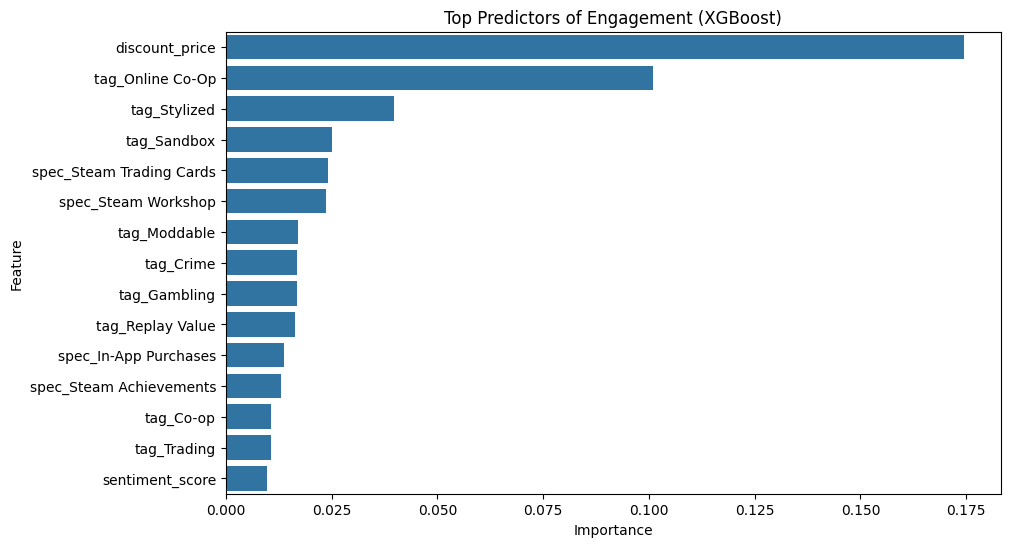

In [53]:
# Show top 15 features
imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_})
top_imp = imp.sort_values(by='Importance', ascending=False).head(15)
print(top_imp)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_imp)
plt.title('Top Predictors of Engagement (XGBoost)')
plt.show()

                           Feature  Importance
374       spec_Steam Trading Cards    0.053879
1                   discount_price    0.053026
0                            price    0.049672
382                sentiment_score    0.040881
201               tag_Online Co-Op    0.040044
371        spec_Steam Achievements    0.037492
60                       tag_Co-op    0.036240
376            spec_Steam Workshop    0.030299
251                    tag_Sandbox    0.024031
342                     spec_Co-op    0.023298
181                   tag_Moddable    0.022608
379  spec_Valve Anti-Cheat enabled    0.020360
240               tag_Replay Value    0.019825
185                tag_Multiplayer    0.019745
383                       game_age    0.018674


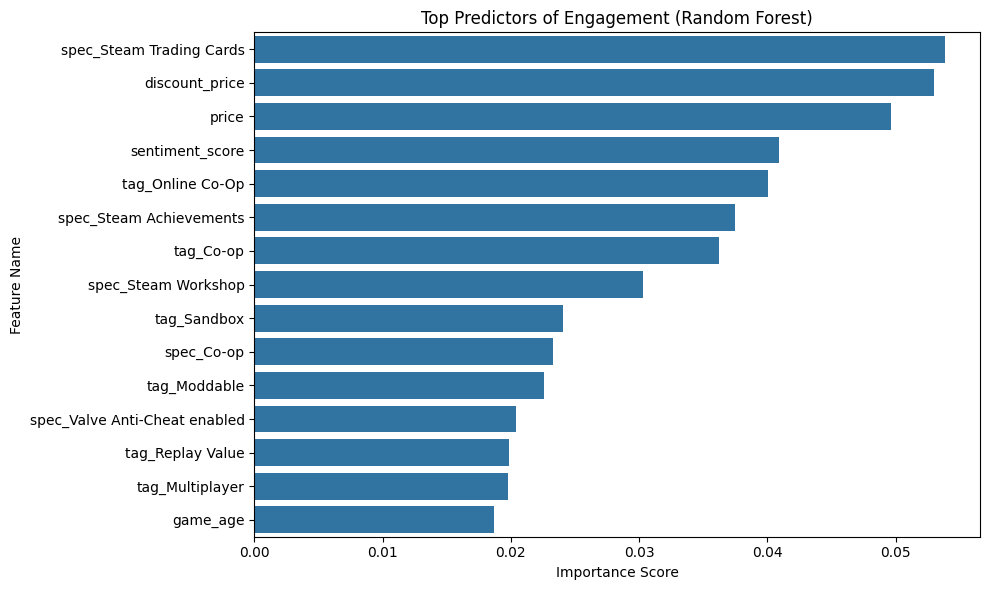

In [54]:
# --- Random Forest Feature Importance ---
rf_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})
top_rf_imp = rf_imp.sort_values(by='Importance', ascending=False).head(15)
print(top_rf_imp)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_rf_imp)
plt.title('Top Predictors of Engagement (Random Forest)')
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


# Recommendation Engine

In [55]:
def recommend_games(user_id, model, item_matrix, top_k=10):
    """
    1. Identify games the user already owns (to exclude them).
    2. Select a pool of Candidate Games (e.g., 100 random unowned games).
    3. Construct the Feature Vector for these candidates.
    4. Ask the Model to predict the probability of playing.
    5. Return the Top K games with the highest probability.
    """

    # 1. Get User History
    try:
        user_history = set(user_matrix[user_matrix['steam_id'] == user_id]['item_id'])
    except:
        user_history = set()

    # 2. Candidate Generation
    # pick 100 random games the user DOESN'T own.
    item_matrix['item_id'] = item_matrix['item_id'].astype(int)
    all_items = set(item_matrix['item_id'])
    candidates = list(all_items - user_history)

    # Safety check: if user owns almost everything
    if len(candidates) > 100:
        candidates = random.sample(candidates, 100)

    # 3. Build Prediction DataFrame
    # grab metadata for these candidates from item_matrix
    candidate_df = item_matrix[item_matrix['item_id'].isin(candidates)].copy()

    # IMPORTANT: ensure columns match X_train exactly!
    # (Drop non-feature columns like ID or raw strings)
    # We use the same 'drop_cols' logic from training
    X_pred = candidate_df.drop(columns=['item_id'], errors='ignore')
    X_pred = X_pred.select_dtypes(include=[np.number])

    # 4. Score Candidates
    # We use predict_proba to get the specific % chance (e.g., 0.85)
    # [:, 1] gets the probability of Class 1 (Played)
    probs = model.predict_proba(X_pred)[:, 1]

    # 5. Rank
    candidate_df['probability'] = probs
    recommendations = candidate_df.sort_values(by='probability', ascending=False).head(top_k)

    # return recommendations[['item_id', 'probability', 'popularity_log', 'price']]
    return recommendations[['item_id', 'probability', 'price']]

### Demo

In [56]:
# RECOMMEND FOR A RANDOM USER

# Pick a random user from the test set
random_user = user_matrix['steam_id'].sample(1).values[0]

print(f"Generating Recommendations for User: {random_user}")
recs = recommend_games(random_user, xgb, item_matrix)

# Merge with item names
steam_games['id'] = steam_games['id'].astype(int)
recs_readable = recs.merge(steam_games[['id', 'app_name']], left_on='item_id', right_on='id', how='left')

print("\nTop 10 Recommended Games:")
print(recs_readable[['app_name', 'probability', 'price']])

Generating Recommendations for User: 76561198039229372

Top 10 Recommended Games:
                app_name  probability  price
0               Leylines     0.896331    NaN
1  Adventuring Gentleman     0.858829   7.99
2         Quest of Souls     0.666868    NaN
3                   RIDE     0.586456  39.99
4            Disoriented     0.510014   3.99
5  BOMB Dedicated Server     0.502827    NaN
6       Log Drive Runner     0.430562   6.99
7              Base Raid     0.424594   7.99
8    Fabulous Food Truck     0.403539   4.99
9           Delve Deeper     0.373728   4.99


In [57]:
def show_recommendations_with_images(recs_df):
    """
    Takes the recommendation dataframe and renders an HTML table
    with game box art using Steam's public CDN.
    """
    html = "<h3>Top 10 Personalized Recommendations</h3>"
    html += "<table style='width:100%; text-align:left;'>"
    html += "<tr><th>Image</th><th>Game Title</th><th>Confidence</th><th>Price</th></tr>"

    for _, row in recs_df.iterrows():
        app_id = row['item_id']
        name = row['app_name']
        prob = row['probability']
        price = row['price']

        # Steam Header Image URL Pattern
        img_url = f"https://cdn.akamai.steamstatic.com/steam/apps/{app_id}/header.jpg"

        # formatting
        prob_color = "green" if prob > 0.8 else "orange" if prob > 0.5 else "red"

        html += f"""
        <tr>
            <td style='width:150px'><img src='{img_url}' style='width:120px; border-radius:5px;'></td>
            <td style='font-weight:bold; font-size:14px'>{name}</td>
            <td style='color:{prob_color}; font-weight:bold'>{prob:.1%}</td>
            <td>${price}</td>
        </tr>
        """
    html += "</table>"
    display(HTML(html))

# Run it on your results
# Make sure your recs_readable has 'item_id' (it might have been lost in merge or named 'id')
recs_readable['item_id'] = recs_readable['id'] # Ensure ID is there
show_recommendations_with_images(recs_readable)

Image,Game Title,Confidence,Price
,Leylines,89.6%,$nan
,Adventuring Gentleman,85.9%,$7.99
,Quest of Souls,66.7%,$nan
,RIDE,58.6%,$39.99
,Disoriented,51.0%,$3.99
,BOMB Dedicated Server,50.3%,$nan
,Log Drive Runner,43.1%,$6.99
,Base Raid,42.5%,$7.99
,Fabulous Food Truck,40.4%,$4.99
,Delve Deeper,37.4%,$4.99
